In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm
import scipy.io as scio

In [2]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
#     np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds = 10):
#     np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
#                 p_value = np.random.random()*p_max # [0, 1] * pmax
#                 p_value = 1e-1
#                 p[i][int(degree_clone[i]-degree[i])] = p_value
#                 p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix

# # @jit(nopython = True)
# def sigma_check(p,degree):
#     sigma = np.zeros(p.shape[0])
#     for i in range(p.shape[0]):
#         sigma[i] = degree[i]*p[i].sum()
#     return sigma

In [3]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0
###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [4]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [6]:
import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [7]:
def init_network(K):
    N = 10**5
    K = 10
    k_min = 2
    k_max = N - 1
    # sigma = 1
#     p_value = 1e-1

    degree = Degree_generate_homo(N, K, k_min, k_max)
    # print(np.max(degree))
    # print(np.random.randint(degree.size))
    # plt.plot(degree)
    degree_clone = degree.copy()
    network_connection = network_generate(K, degree_clone, 10)

#     ## propagation matrix 
#     network_p = np.copy(network_connection)
#     network_p[np.where(network_p != 0.0)] = p_value

    ## degree 
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    return network_connection,network_degree

In [13]:
traget_sigma = np.arange(0.6,1.61,0.01)
traget_sigma
P = traget_sigma/10
print(P)

[0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071
 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083
 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095
 0.096 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107
 0.108 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119
 0.12  0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131
 0.132 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143
 0.144 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155
 0.156 0.157 0.158 0.159 0.16  0.161]


In [ ]:
traget_sigma = np.arange(0.6,1.61,0.01)

k = 10
run = 1
while run<101:
    N = 10**5 
    P = traget_sigma/k
    print(P)
    rho2 = []
    sigmas2 = []
    taus2 = []
    F02 = []

    times = 5050
    r = 1/N
    n = 10
    t_test = np.arange(times)
    network_connection, network_degree = init_network(k)
    print('********************************')
    print('Generated network with avaerage degree :%d'%(k))
    print('********************************')
        
    for p in P:
        
        network_p = np.copy(network_connection)
        network_p[np.where(network_p != 0.0)] = p
        
        network_connection_clone = np.copy(network_connection)
        network_degree_clone = np.copy(network_degree)
        network_p_clone = np.copy(network_p)

        print('==> ==> ==> sigma: %f'%round(network_degree_clone.sum()/N*p,2))

        rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
        rho2.append(rho_test)
        tau2 = decay(rho_test,25)
        taus2.append(tau2[1])
        sigmas2.append(round(network_degree_clone.sum()/N*p,2))
        F02.append(F0_determine(rho_test))

    scio.savemat(f'modelling/Timeseries_{run}_0317.mat',{'sigmas':sigmas2,'rho':rho2,'intf':taus2,'F0':F02})
    run = run+1

[0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071
 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083
 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095
 0.096 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107
 0.108 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119
 0.12  0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131
 0.132 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143
 0.144 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155
 0.156 0.157 0.158 0.159 0.16  0.161]
********************************
Generated network with avaerage degree :10
********************************
==> ==> ==> sigma: 0.600000
==> ==> ==> sigma: 0.610000
==> ==> ==> sigma: 0.620000
==> ==> ==> sigma: 0.630000
==> ==> ==> sigma: 0.640000
==> ==> ==> sigma: 0.650000
==> ==> ==> sigma: 0.660000
==> ==> ==> sigma: 0.670000
==> ==> ==> sigma: 0.680000
==> ==> ==> sigma

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20204\664203981.py:13: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-(x/tau)) + b


==> ==> ==> sigma: 1.570000
==> ==> ==> sigma: 1.580000
==> ==> ==> sigma: 1.590000
==> ==> ==> sigma: 1.600000
==> ==> ==> sigma: 1.610000
[0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071
 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083
 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095
 0.096 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107
 0.108 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119
 0.12  0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131
 0.132 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143
 0.144 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155
 0.156 0.157 0.158 0.159 0.16  0.161]
********************************
Generated network with avaerage degree :10
********************************
==> ==> ==> sigma: 0.600000
==> ==> ==> sigma: 0.610000
==> ==> ==> sigma: 0.620000
==> ==> ==> sigma: 0.630000
==> ==> ==> sigma

In [47]:
F0

array([[3.269000e-05, 3.659000e-05, 4.177000e-05, 4.854000e-05,
        5.618000e-05, 7.644000e-05, 1.091700e-04, 2.159000e-04,
        9.882100e-04, 4.628220e-03, 8.977330e-03, 1.315026e-02,
        1.695734e-02, 2.051505e-02, 2.374762e-02, 2.676416e-02,
        2.966294e-02, 3.233985e-02, 3.475318e-02, 3.707850e-02,
        3.916606e-02, 4.120211e-02, 4.274446e-02, 4.379481e-02,
        4.462653e-02, 4.548168e-02, 4.631767e-02, 4.704046e-02]])

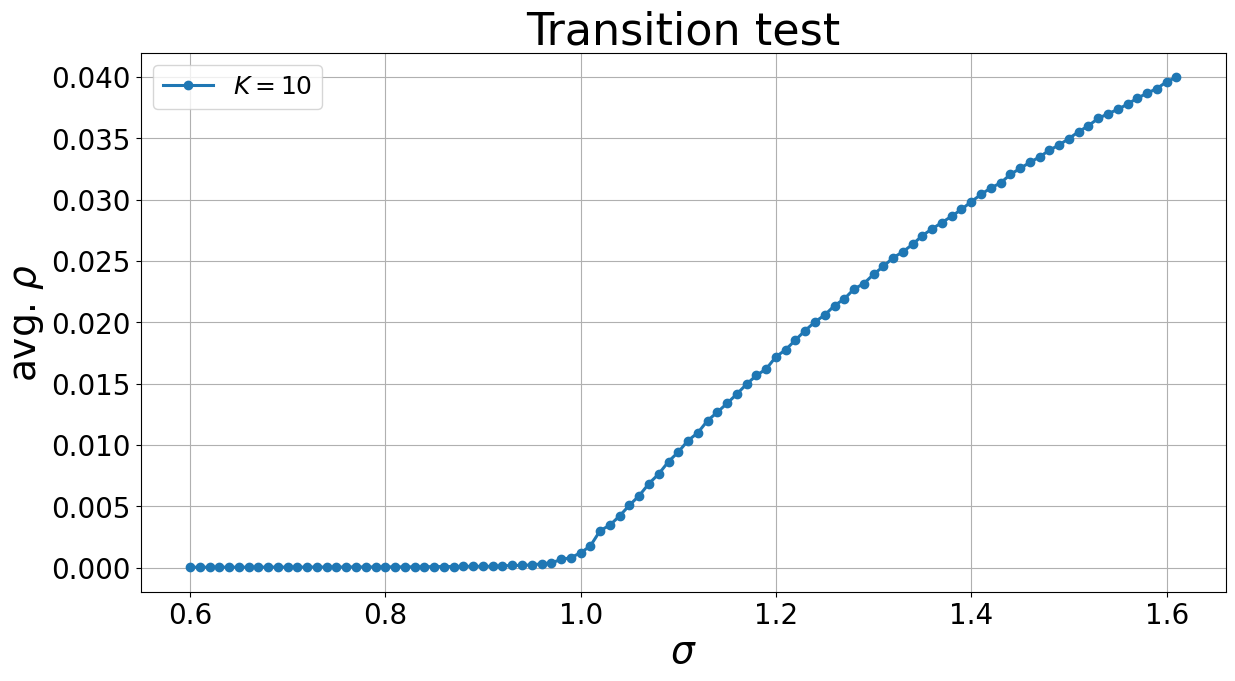

In [3]:
fig, ax = plt.subplots(figsize=(14, 7))
k = 10
run = 0
while run <10:
    timeseries = scio.loadmat(f'modelling/Timeseries_{run+1}_0317.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    # print(p,F0)
    ax.plot(sigmas[0], F0[0],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ K = %d $'%(k))
    break

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('avg. $\\rho$ ',fontsize=27)
ax.set_title('Transition test',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

In [174]:
s4[20:-10]

array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
       1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42])

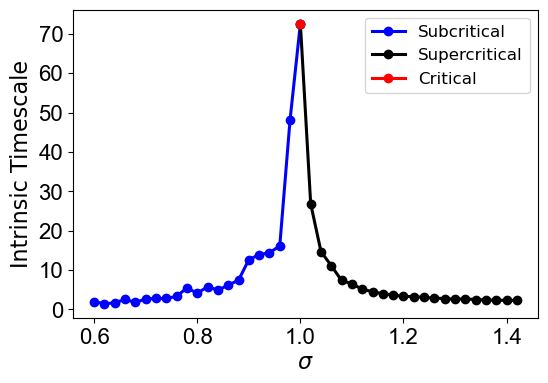

In [197]:
fig, ax = plt.subplots(figsize=(6, 4))
k = 10
run = 1
int4 = []
while run < 2:
    timeseries = scio.loadmat(f'modelling/Timeseries_{run+1}_0317.mat')
    sigmas = timeseries['sigmas'][0]
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    # print(p,F0)
#     print(taus[0])
#     break
    for i,r in enumerate(rho):
        int4.append(intrinic_timescale0(r[100:]))
    s4 = np.concatenate((sigmas[:90][::2],sigmas[-21:][::3]),axis = 0)
    t4 = np.concatenate((int4[:90][::2],int4[-21:][::3]),axis = 0)
    
    # t5 = np.hstack((s4[:15],t4[16:]))
    # s5 = np.hstack((s4[:15],s4[16:]))
    ax.plot(s4[:21], t4[:21], color='blue', linewidth = 2.2, linestyle='-', marker = 'o', label = 'Subcritical')
    ax.plot(s4[20:-10], t4[20:-10], color='black', linewidth = 2.2, linestyle='-', marker = 'o', label = 'Supercritical')
    ax.plot(s4[20:21], t4[20:21], color='red', linewidth = 2.2, linestyle='-', marker = 'o', label = 'Critical')
   
    # k = k+1break
    break
    
# ax.annotate(f'$\sigma = $ 1.00',
#                         xy=(s4[np.argmax(t2)], t4.max()),
#                         xytext=(8,-4),  # 4 points vertical offset.
#                         textcoords='offset points')
# plt.xticks(fontsize= 10)
# plt.yticks(fontsize= 10)

ax.set_xlabel('$\sigma$',fontsize= 16, family ='Arial')
ax.set_ylabel('Intrinsic Timescale',fontsize= 16)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(family ='Arial',fontsize= 16)
plt.yticks(fontsize= 16, family ='Arial')
# font_prop = font_manager.FontProperties(size = 14, weight = 4, family = 'Arial')
labels = ax.get_xticklabels() + ax.get_yticklabels()
ax.legend(fontsize = 12)
plt.savefig(f'intvsfor1.png', dpi = 300, bbox_inches='tight')
plt.show()

In [7]:
# print(rsn_timeseries.shape)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
def intrinic_timescale_interp(intter):
    # autocorr = stattools.acf(ica)
    return np.sum(intter[1:list(intter<0).index(True)])

def intrinic_timescale0(ica):
    autocorr = stattools.acf(ica,nlags = 1000)
    return np.sum(autocorr[1:list(autocorr<0).index(True)])

def intrinic_timescale5(ica):
    autocorr = stattools.acf(ica,nlags = 1000)
    return np.sum(autocorr[1:list(autocorr<0.5).index(True)])
    
def calculate_acorr_per_subj(icas):
    return [intrinic_timescale(ica) for ica in icas ]

def network_agv(it_icas):
    dmn = np.mean(it_icas[:11])
    smn = np.mean(it_icas[11:17])
    vis = np.mean(it_icas[17:29])
    sc = np.mean(it_icas[29:36])
    cc = np.mean(it_icas[36:54])
    aud = np.mean(it_icas[54:60])
    return [dmn,smn,vis,sc,cc,aud]

def acf_curve(icas):
  return np.array([stattools.acf(ica) for ica in icas])

In [193]:
from scipy.stats import sem
k = 10
trails = 50
taus = []
f0s = []
chis = []
int0s = []
int5s = []
sigma = []
for run in range(trails):   
    timeseries = scio.loadmat(f'modelling/Timeseries_{run+1}_0317.mat')
    rho = timeseries['rho']
    sigma = timeseries['sigmas'][0]
    int0 = []
    int5 = []
    for i,r in enumerate(rho):
        int0.append(intrinic_timescale0(r[100:]))
        int5.append(intrinic_timescale5(r[100:]))
    int0s.append(int0)
    int5s.append(int5)


(102, 5050)

In [194]:
from scipy.stats import sem

int0s = np.array(int0s)
int5s = np.array(int5s)

print(int0s.shape)
print(int5s.shape)
mean_int0s = np.mean(int0s,0)
mean_int5s = np.mean(int5s,0)

print(mean_int0s)
print(mean_int0s.shape)

sem0 = sem(int0s)
sem5 = sem(int5s)

(50, 102)
(50, 102)
[ 1.55163809  1.5991946   1.68055329  1.76735728  1.86945033  1.89555553
  2.06665337  2.17762252  2.20395091  2.31076463  2.40240078  2.64584263
  2.74565796  2.81146913  2.93998943  3.1509998   3.29393344  3.60033684
  3.82076476  3.92205794  4.28587624  4.63848068  4.6065099   5.19376201
  5.82089071  5.90610979  6.3603795   7.26622732  7.83126531  9.35997374
  9.7473449  11.10484451 12.61763469 13.9138926  16.45632389 19.9630968
 24.76862221 29.17870395 35.54370723 51.48237316 50.17162783 43.00730793
 34.15308251 23.1013431  16.87932609 13.69582547 11.92728266  9.66772495
  8.37088382  7.11509121  6.01806524  5.36001674  5.02469035  4.63372668
  4.3653292   4.10753631  3.92867708  3.79225895  3.61356857  3.48836015
  3.37568463  3.26524263  3.15716133  3.07552124  2.98898904  2.92223926
  2.85176014  2.80552067  2.71838135  2.68154794  2.64499307  2.59689519
  2.56005281  2.53314135  2.4950658   2.46542102  2.43068262  2.40064036
  2.35441689  2.33330525  2.3050

In [31]:
sigma

array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03,
       1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14,
       1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25,
       1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36,
       1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47,
       1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58,
       1.59, 1.6 , 1.61])

In [75]:
t2.shape
s2.shape
sem2.shape
print(s2)
print(sigma[:92][::2])

[0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86
 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1  1.12 1.14
 1.16 1.18 1.2  0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02
 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.41 1.44 1.47 1.5  1.53
 1.56 1.59]
[0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86
 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1  1.12 1.14
 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38 1.4  1.42
 1.44 1.46 1.48 1.5 ]


In [190]:
t3

array([ 1.55163809,  1.68055329,  1.86945033,  2.06665337,  2.20395091,
        2.40240078,  2.74565796,  2.93998943,  3.29393344,  3.82076476,
        4.28587624,  4.6065099 ,  5.82089071,  6.3603795 ,  7.83126531,
       12.61763469, 16.45632389, 24.76862221, 35.54370723, 50.17162783,
       34.15308251, 16.87932609, 11.92728266,  8.37088382,  6.01806524,
        5.02469035,  4.3653292 ,  3.92867708,  3.61356857,  3.37568463,
        3.15716133,  2.98898904,  2.85176014,  2.71838135,  2.64499307,
        2.56005281,  2.4950658 ,  2.43068262,  2.35441689,  2.30508493,
        2.28126539,  2.25013278,  2.22935728,  2.20379341,  2.28737701,
        2.25013278,  2.21281676,  2.18920324,  2.15768546,  2.13232681,
        2.12066365])

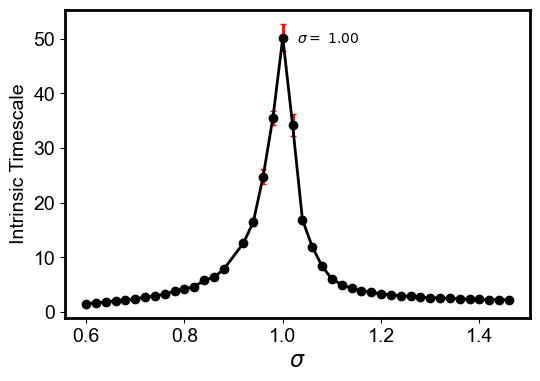

In [195]:

# print(sigma[:-31])
fig, ax = plt.subplots(figsize=(6, 4))
# s1 = np.concatenate((sigma[:-31], sigma[-31:][::3]),axis = 0)
# t1 = np.concatenate((tau[:-31],tau[-31:][::3]),axis = 0)
# print(s1)
# print(t1)
s2 = np.concatenate((sigma[:90][::2],sigma[-21:][::3]),axis = 0)
t2 = np.concatenate((mean_int0s[:90][::2],mean_int0s[-21:][::3]),axis = 0)
sem2 = np.concatenate((sem0[:90][::2], sem0[-21:][::3]),axis = 0)
# tempp =  t2[34]
# t2[34] = t2[35]
# t2[35] = tempp
t3 = np.hstack((t2[:15],t2[16:]))
sem3 = np.hstack((sem2[:15],sem2[16:]))
s3 = np.hstack((s2[:15],s2[16:]))

# ax.errorbar(sigma,mean_int0s, yerr = sem0, color='black', capsize=2, ecolor= 'r', linewidth= 2.0, linestyle='-', marker = 'o',label = 'INT (AUC across 0)')

ax.errorbar(s3[:-8],t3[:-8], yerr = sem3[:-8], color='black', capsize=2, ecolor= 'r', linewidth= 2.0, linestyle='-', marker = 'o')
# ax.errorbar(s3[19:],t3[19:], yerr = sem3[19:], color='red', capsize=2, ecolor= 'r', linewidth= 2.0, linestyle='-', marker = 'o',label = 'Supercritical')
# ax.errorbar(s3[19:20],t3[19:20], yerr = sem3[19:20], color='black', capsize=2, ecolor= 'r', linewidth= 2.0, linestyle='-', marker = 'o',label = 'Critical')

# ax.errorbar(s2[33:],t2[33:], yerr = sem2[33:], color='black', capsize=2,ecolor= 'r',linewidth= 2.0, linestyle='-', marker = 'o')
# ax.errorbar(s2[33:34],t2[33:34], yerr = sem2[33:34], color='black',capsize=2,ecolor= 'r', linewidth= 2.0, linestyle='-', marker = 'o')


# ax.set_xlabel('$\sigma$',fontsize=15)
# ax.set_ylabel('Intrinsic Timescale(Avg $\pm$ SE)',fontsize=15)
# # ax.set_title('',fontsize=15)

# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
ax.annotate(f'$\sigma = $ 1.00',
                        xy=(s2[np.argmax(t2)], t2.max()),
                        xytext=(10,-4),  # 4 points vertical offset.
                        textcoords='offset points')
# plt.xticks(fontsize= 10)
# plt.yticks(fontsize= 10)

ax.set_xlabel('$\sigma$',fontsize= 16, family ='Arial')
ax.set_ylabel('Intrinsic Timescale',fontsize= 14,family ='Arial')
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(family ='Arial',fontsize= 14)
plt.yticks(fontsize= 14,family ='Arial')
font_prop = font_manager.FontProperties(size = 14, weight = 4, family = 'Arial')
labels = ax.get_xticklabels() + ax.get_yticklabels()
# ax.legend(prop = font_prop)

# plt.ylim((0,50))
# plt.legend()
# font_prop = font_manager.FontProperties(size=9)
# # ax.legend(prop = font_prop)

bwith = 2 #边框宽度设置为2
ax = plt.gca()#获取边框
#设置边框
ax.spines['bottom'].set_linewidth(bwith)#图框下边
ax.spines['left'].set_linewidth(bwith)#图框左边

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['top'].set_linewidth(bwith)#图框上边
ax.spines['right'].set_linewidth(bwith)#图框右边
#取消边框
# plt.grid(color = 'black',linewidth = 1,alpha=0.4)
plt.savefig("INT_k_fixed.png",bbox_inches='tight', pad_inches=0, dpi=300)

(102, 5050)
[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01
 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15
 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29
 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41 1.42 1.43
 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53 1.54 1.55 1.56 1.57
 1.58 1.59 1.6  1.61]
20
40
60


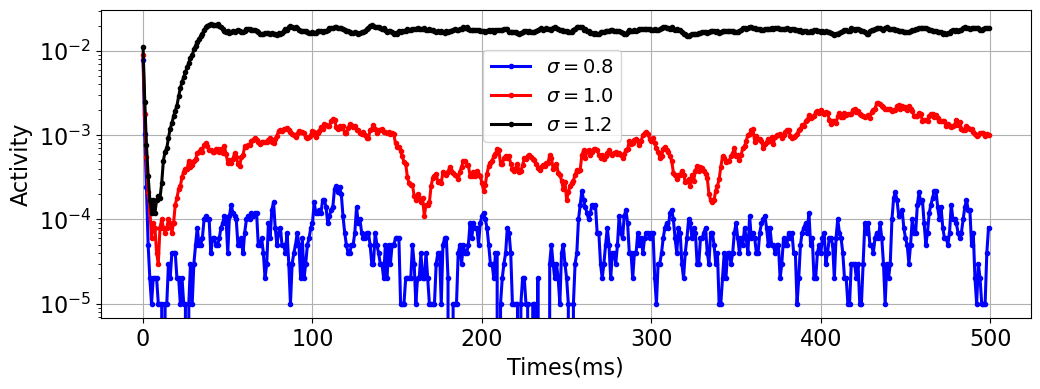

In [153]:
# fig, ax = plt.subplots(figsize=(14, 7))
# rc('font', weight= 2 )
k = 10
run = 1
while run <2 :
    timeseries = scio.loadmat(f'modelling/Timeseries_{run+1}_0317.mat')
    sigmas = timeseries['sigmas'][0]
    rho = timeseries['rho']
    print(rho.shape)
    print(sigmas)
    targets = [0.8, 1.0, 1.2]
    fig, ax = plt.subplots(figsize=(12, 4))
    times = 1000
    t_test = np.arange(times)
    color = ['blue', 'red','black']
    for n, i in enumerate(targets):
        ind = np.where(sigmas == i)[0][0]
        print(ind)
        # print(n//3)
        rho_t = rho[int(ind)]
        ax.plot(t_test[:500], rho_t[:500], marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
                label = '$\sigma=%.1f$'%(i))
    break

ax.set_xlabel('Times(ms)',fontsize=16)
ax.set_ylabel('Activity',fontsize=16)
# ax.set_title('Activity test with varying $\lambda$',fontsize=16)
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
font_prop = font_manager.FontProperties(size= 16)
ax.legend(loc='upper right', bbox_to_anchor=(0.57, 0.9),fontsize = 14)
plt.grid()
# print('Time cost:', time.time()-start_i)
plt.savefig(f'dynamics.png', dpi = 300, bbox_inches='tight')
plt.show()

In [84]:
def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

(102, 5050)
[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01
 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15
 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29
 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41 1.42 1.43
 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53 1.54 1.55 1.56 1.57
 1.58 1.59 1.6  1.61]
20
25
40
25
60
25


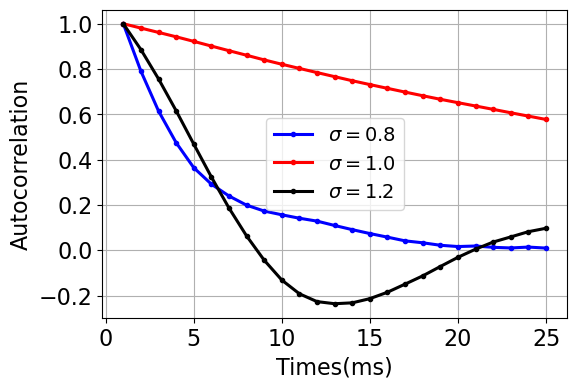

In [92]:
from matplotlib import rc
import pandas as pd
rc('font', weight=2 )

fig, ax = plt.subplots(figsize=(6, 4))

k = 10
curve = []
lag = 25
run = 1
while k<11:
    timeseries = scio.loadmat(f'modelling/Timeseries_{run+1}_0317.mat')
    sigmas = timeseries['sigmas'][0]
    rho = timeseries['rho']
    print(rho.shape)
    print(sigmas)
    targets = [0.8, 1.0, 1.2]
    times = 1000
    t_test = np.arange(times)
    color = ['blue', 'red', 'black']
    for n, i in enumerate(targets):
        ind = np.where(sigmas == i)[0][0]
        print(ind)
        # print(n//3)
        rho_t = rho[int(ind)]
        
        curve1 = autocorr_range(rho_t[50:], range(lag))
        print(len(curve1))
        plt.plot([i+1 for i in range(lag)], curve1, marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
                label = '$\sigma=%.1f$'%(i))
    break

plt.xlabel('Times(ms)',fontsize=16)
plt.ylabel('Autocorrelation',fontsize=16)
# plt.title('Autocorrelation function with varying $\lambda$',fontsize=16)
# plt.set_yscale('log')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
font_prop = font_manager.FontProperties(size = 16)
ax.legend(fontsize = 14)
plt.grid()
# print('Time cost:', time.time()-start_i)
plt.savefig(f'model_acf_curve.png', dpi = 300, bbox_inches='tight')
plt.show()

In [3]:
@jit(nopython = True)
def convert_index_to_matrix(network):
    network_connection_m = np.zeros((network.shape[0],network.shape[0]))

    xys = np.where(network)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])]
    for i in xy:
#         print(i)
        a, b = i[0],i[1]
#         print(a,b)
        ij = network[int(a),int(b)]
        network_connection_m[int(a),int(ij)] = 1
        network_connection_m[int(ij),int(a)] = 1
    return network_connection_m

In [ ]:
network_connection_m = convert_index_to_matrix(network)
# network_connection_m = np.zeros((network.shape[0],network.shape[0]))
# print(network_connection_m.shape)
# xys = np.where(network)
#     # print(xys)
# xy = [i for i in zip(xys[0],xys[1])]
# for i in xy:
# #     print(i)
#     a, b = i[0],i[1]
# #     print(a,b)
#     ij = network[int(a),int(b)]
# #     print(ij)
#     print(int(a),int(ij))
#     break
#     network_connection_m[int(a),int(ij)] = 1
#     network_connection_m[int(ij),int(a)] = 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# data = np.random.random((10,10))
plt.imshow(np.asarray(network_p))
# plt.imshow(np.random.random((50,50)))
plt.colorbar()
plt.show()